# Analysis workbook for simulation testing of pooling-deconvolution workflow

Code for plotting is in `multicat-data/manuscript_SI_figures`.

In [28]:
# running utility functions and base settings
%run '../viz_fns.ipynb'

## Visualizing sample landscapes and accuracy/efficiency distributions

./data/pos0p001_neg0p001/ls/landscape_pos0p001_neg0p001_ls_0_coop_mat.csv


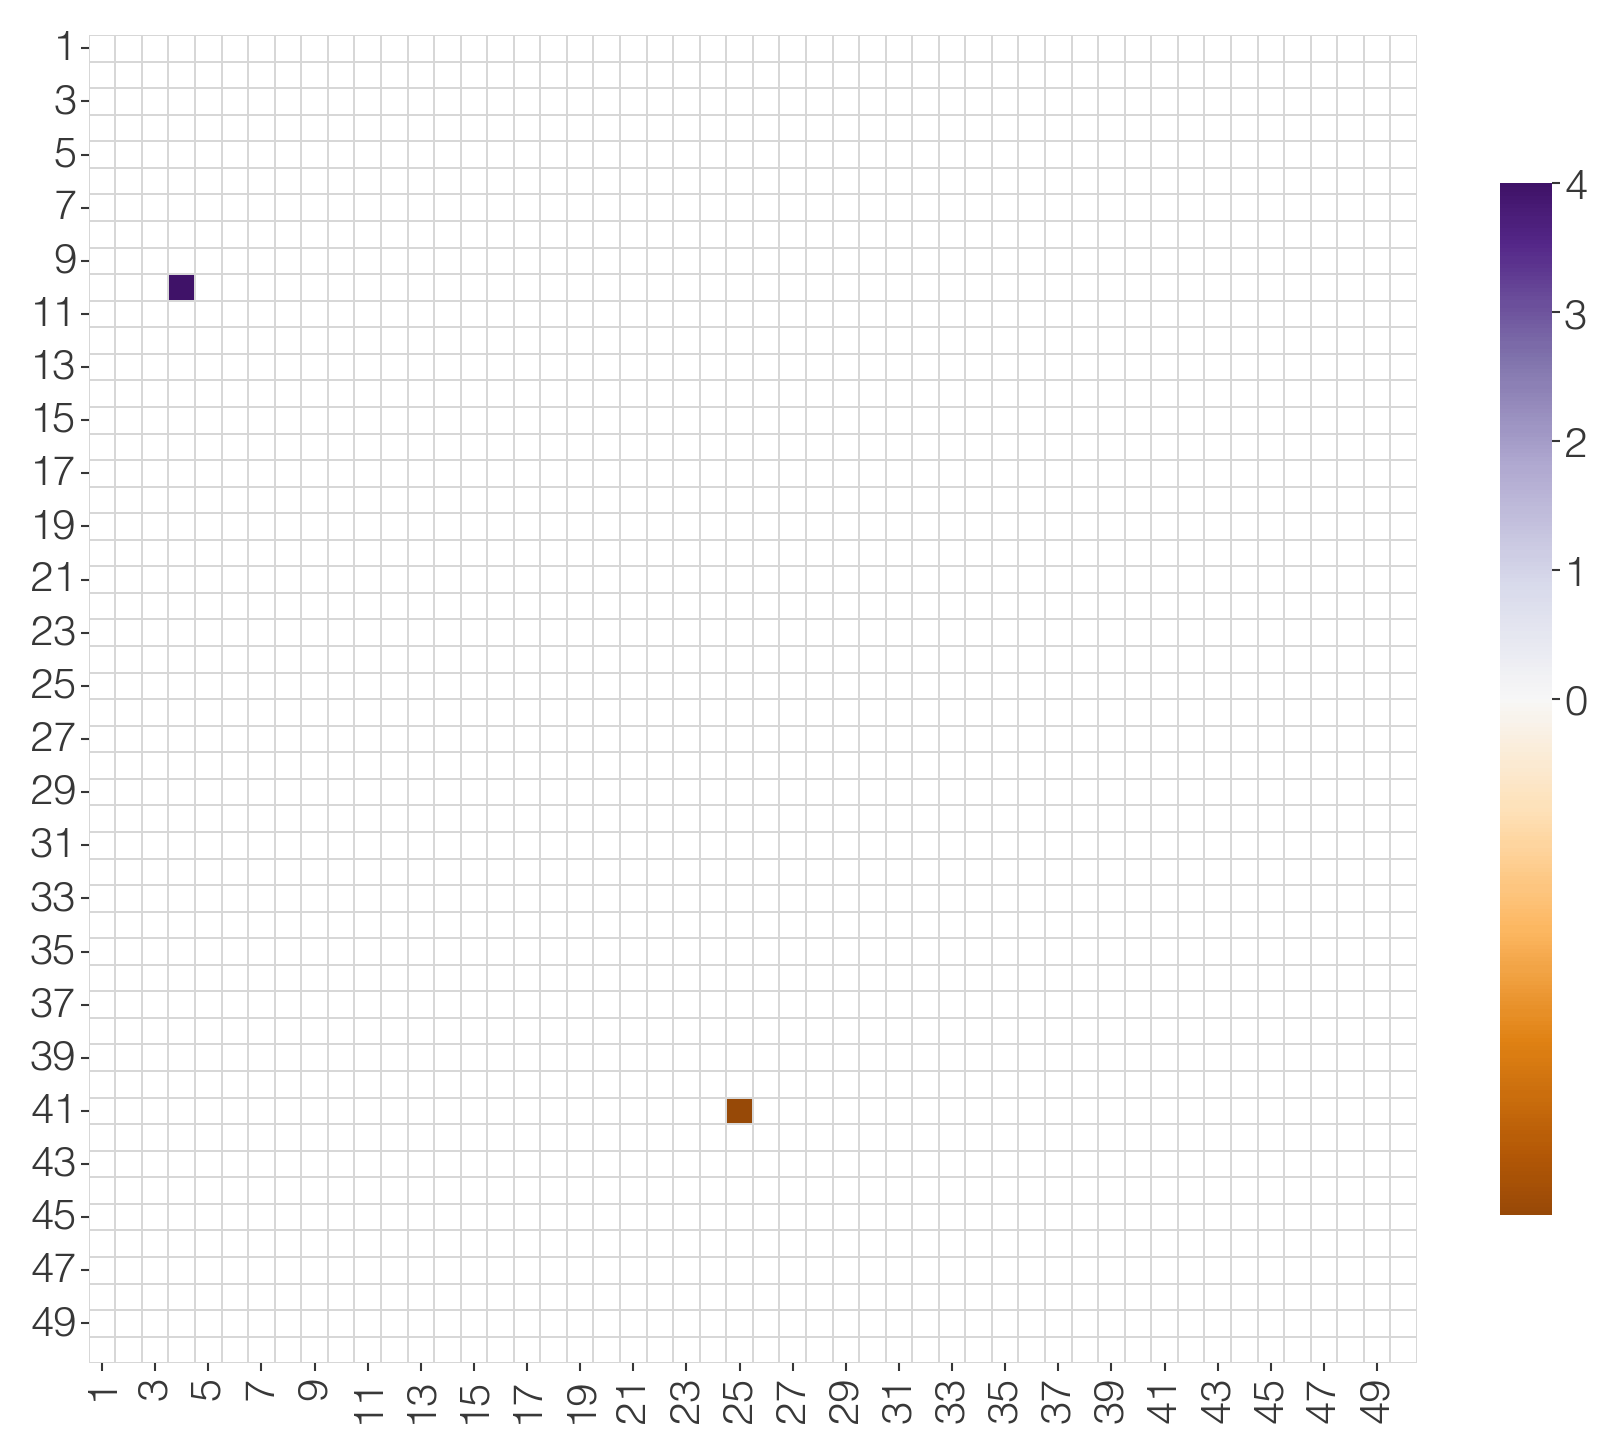

./data/pos0p001_neg0p32/ls/landscape_pos0p001_neg0p32_ls_0_coop_mat.csv


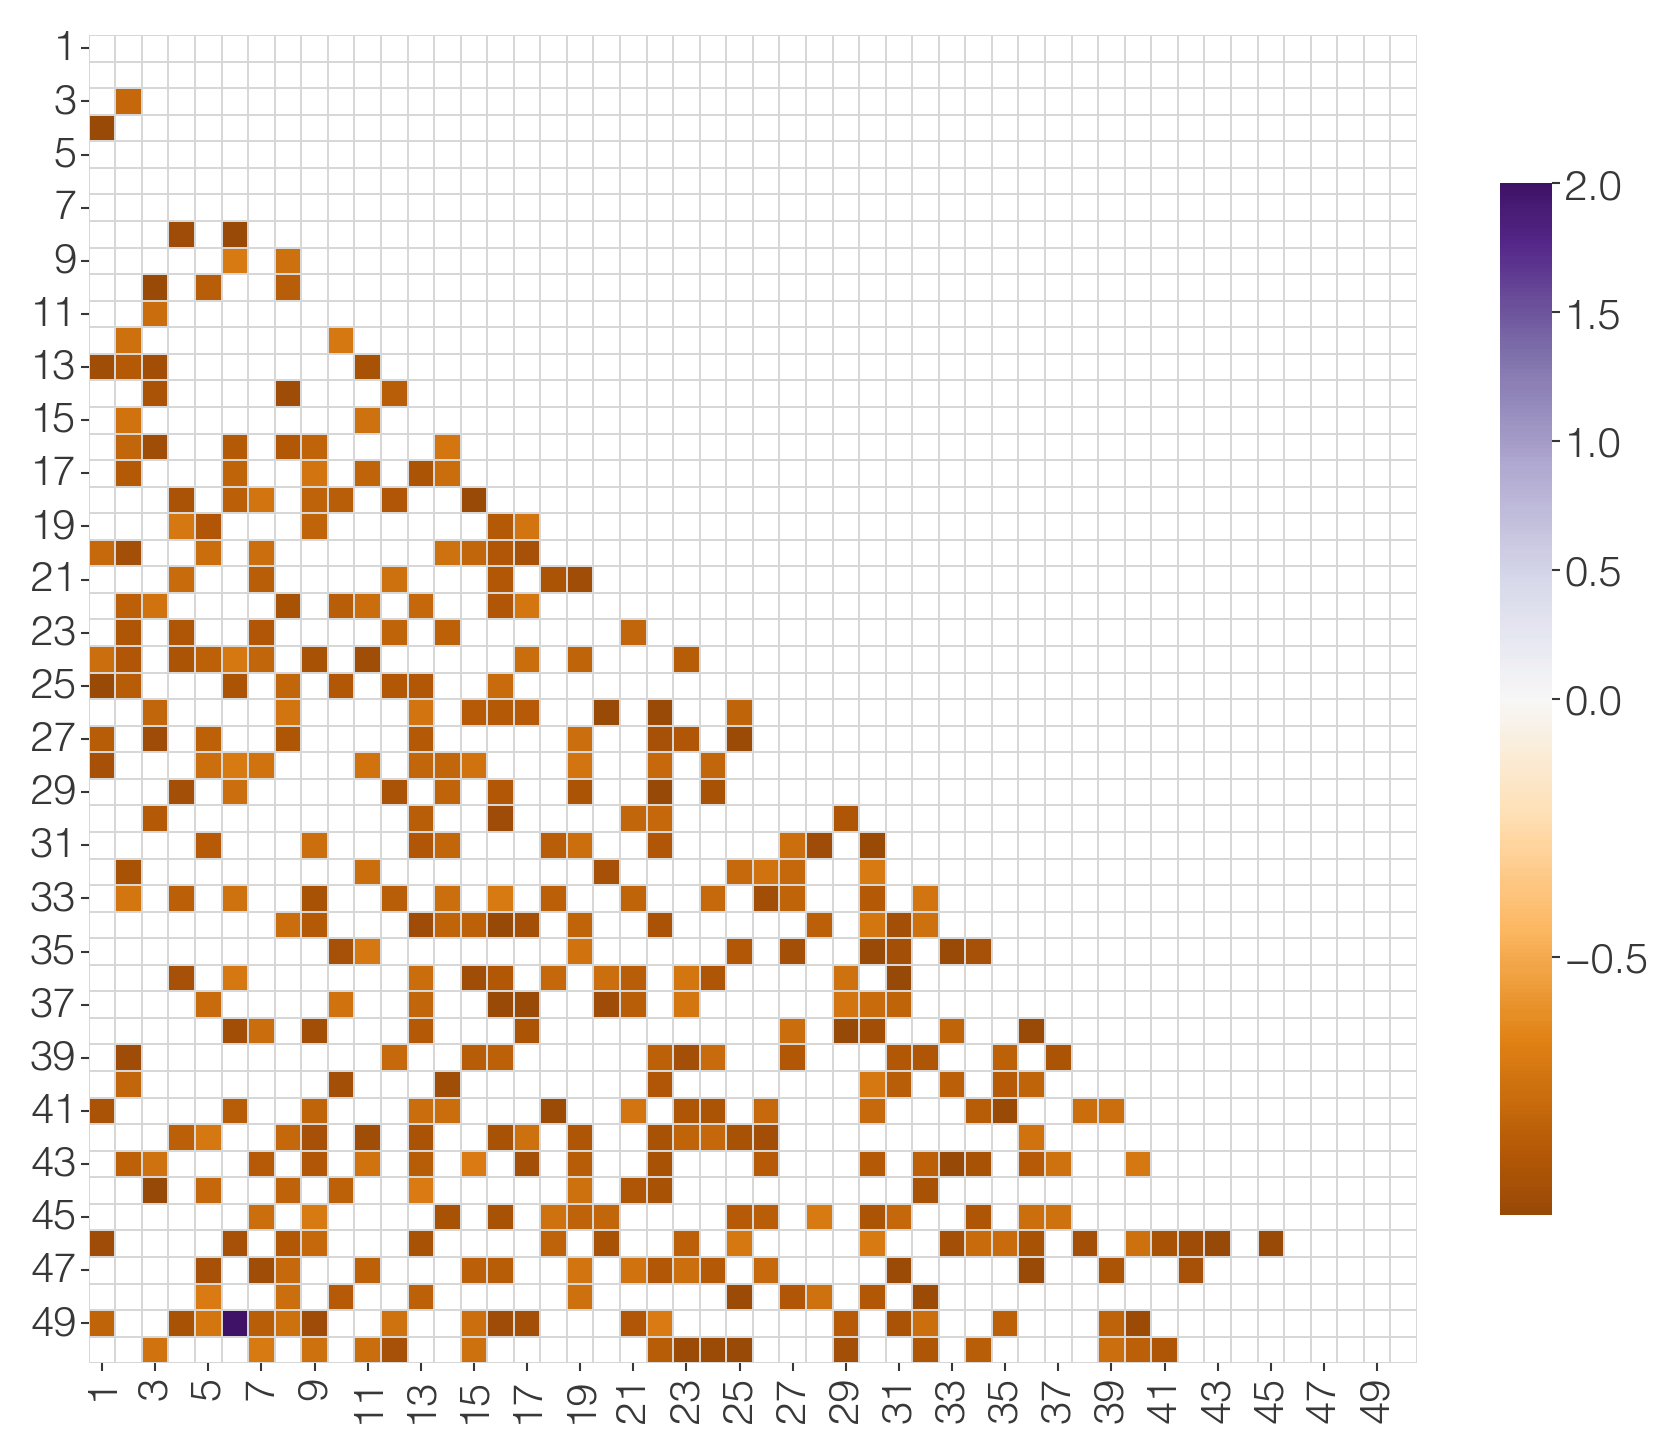

./data/pos0p032_neg0p001/ls/landscape_pos0p032_neg0p001_ls_0_coop_mat.csv


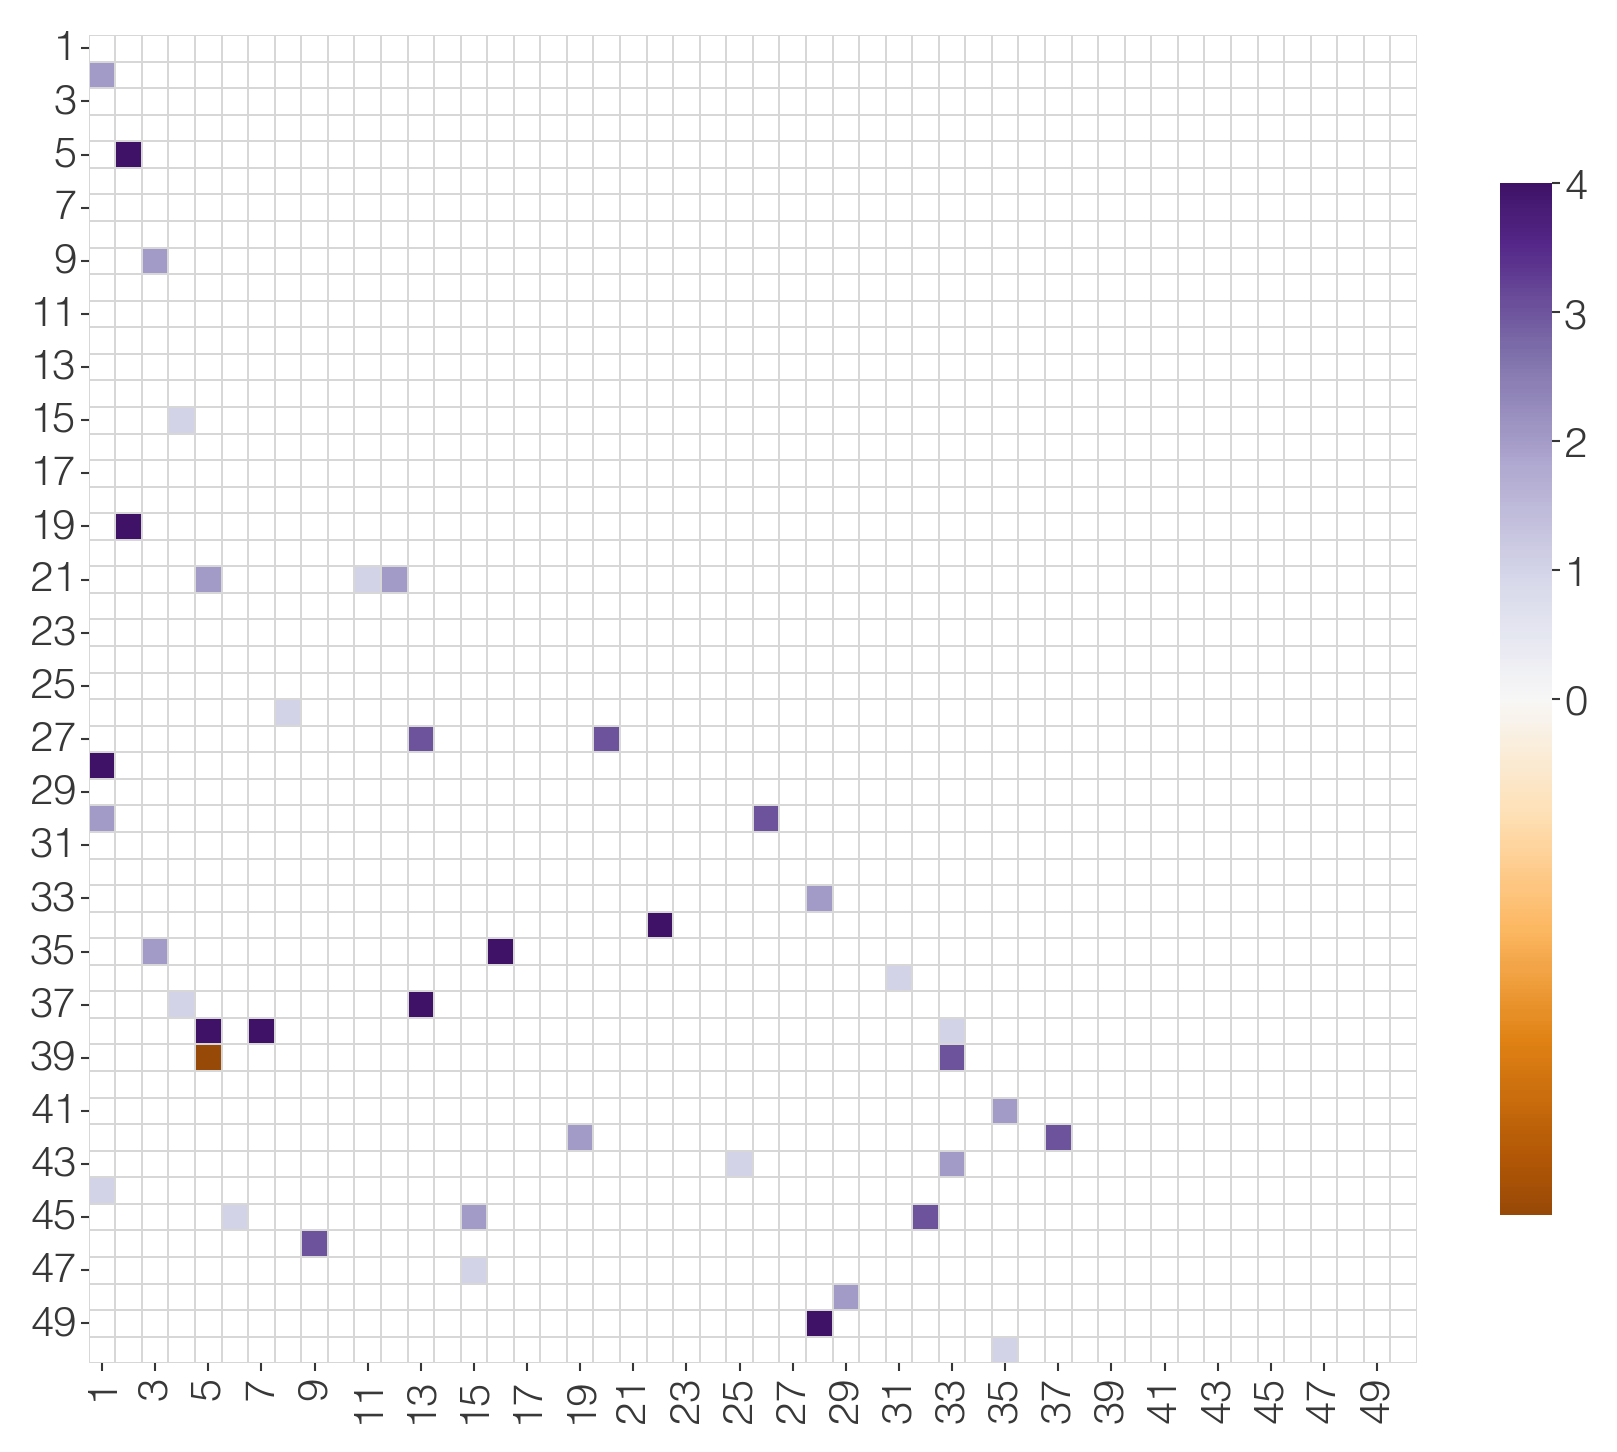

./data/pos0p032_neg0p32/ls/landscape_pos0p032_neg0p32_ls_0_coop_mat.csv


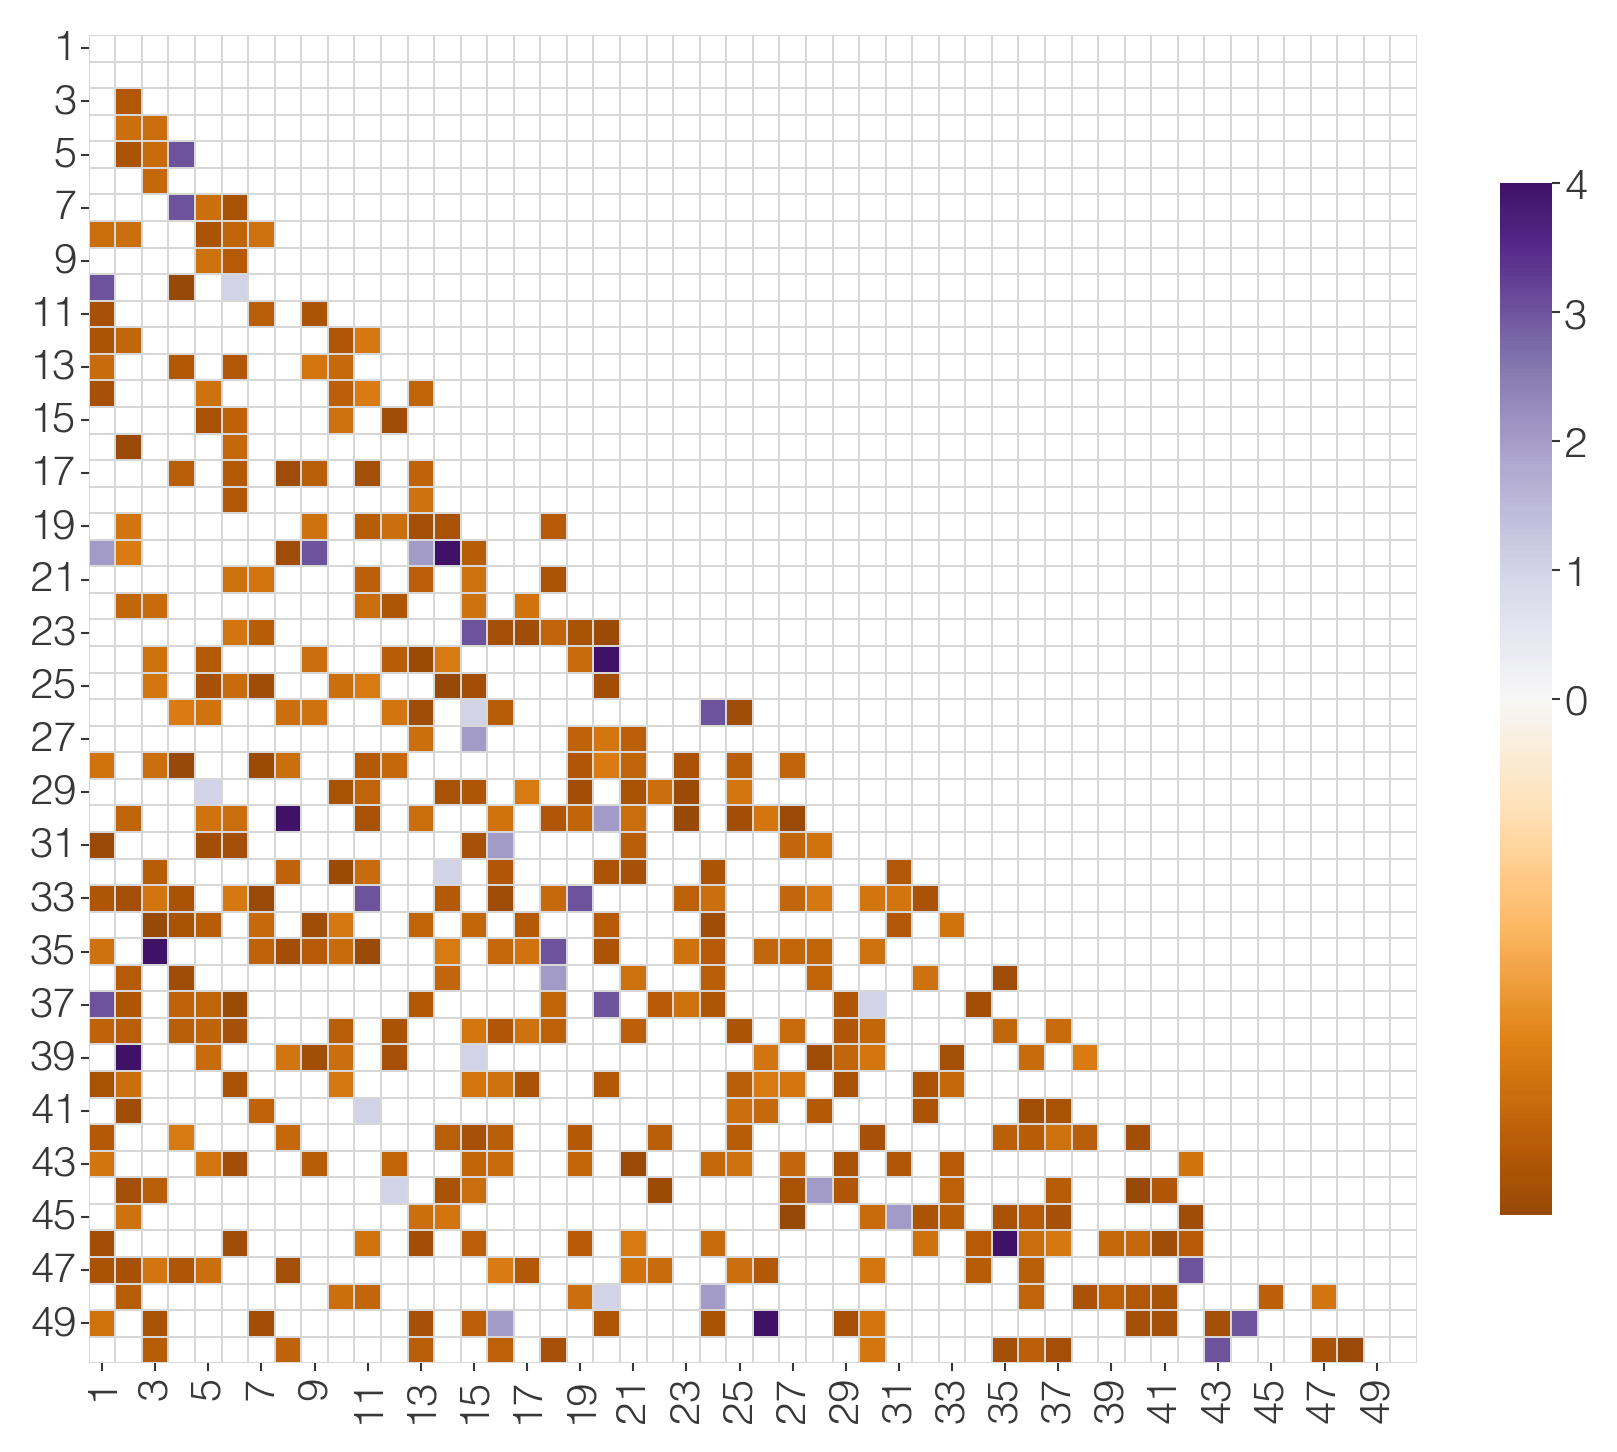

In [29]:
files = ['./data/pos0p001_neg0p001/ls/landscape_pos0p001_neg0p001_ls_0_coop_mat.csv', './data/pos0p001_neg0p32/ls/landscape_pos0p001_neg0p32_ls_0_coop_mat.csv', './data/pos0p032_neg0p001/ls/landscape_pos0p032_neg0p001_ls_0_coop_mat.csv', './data/pos0p032_neg0p32/ls/landscape_pos0p032_neg0p32_ls_0_coop_mat.csv']

for f in files:
    print(f)
    viz_coop_zero_center(50, f, simple=False)

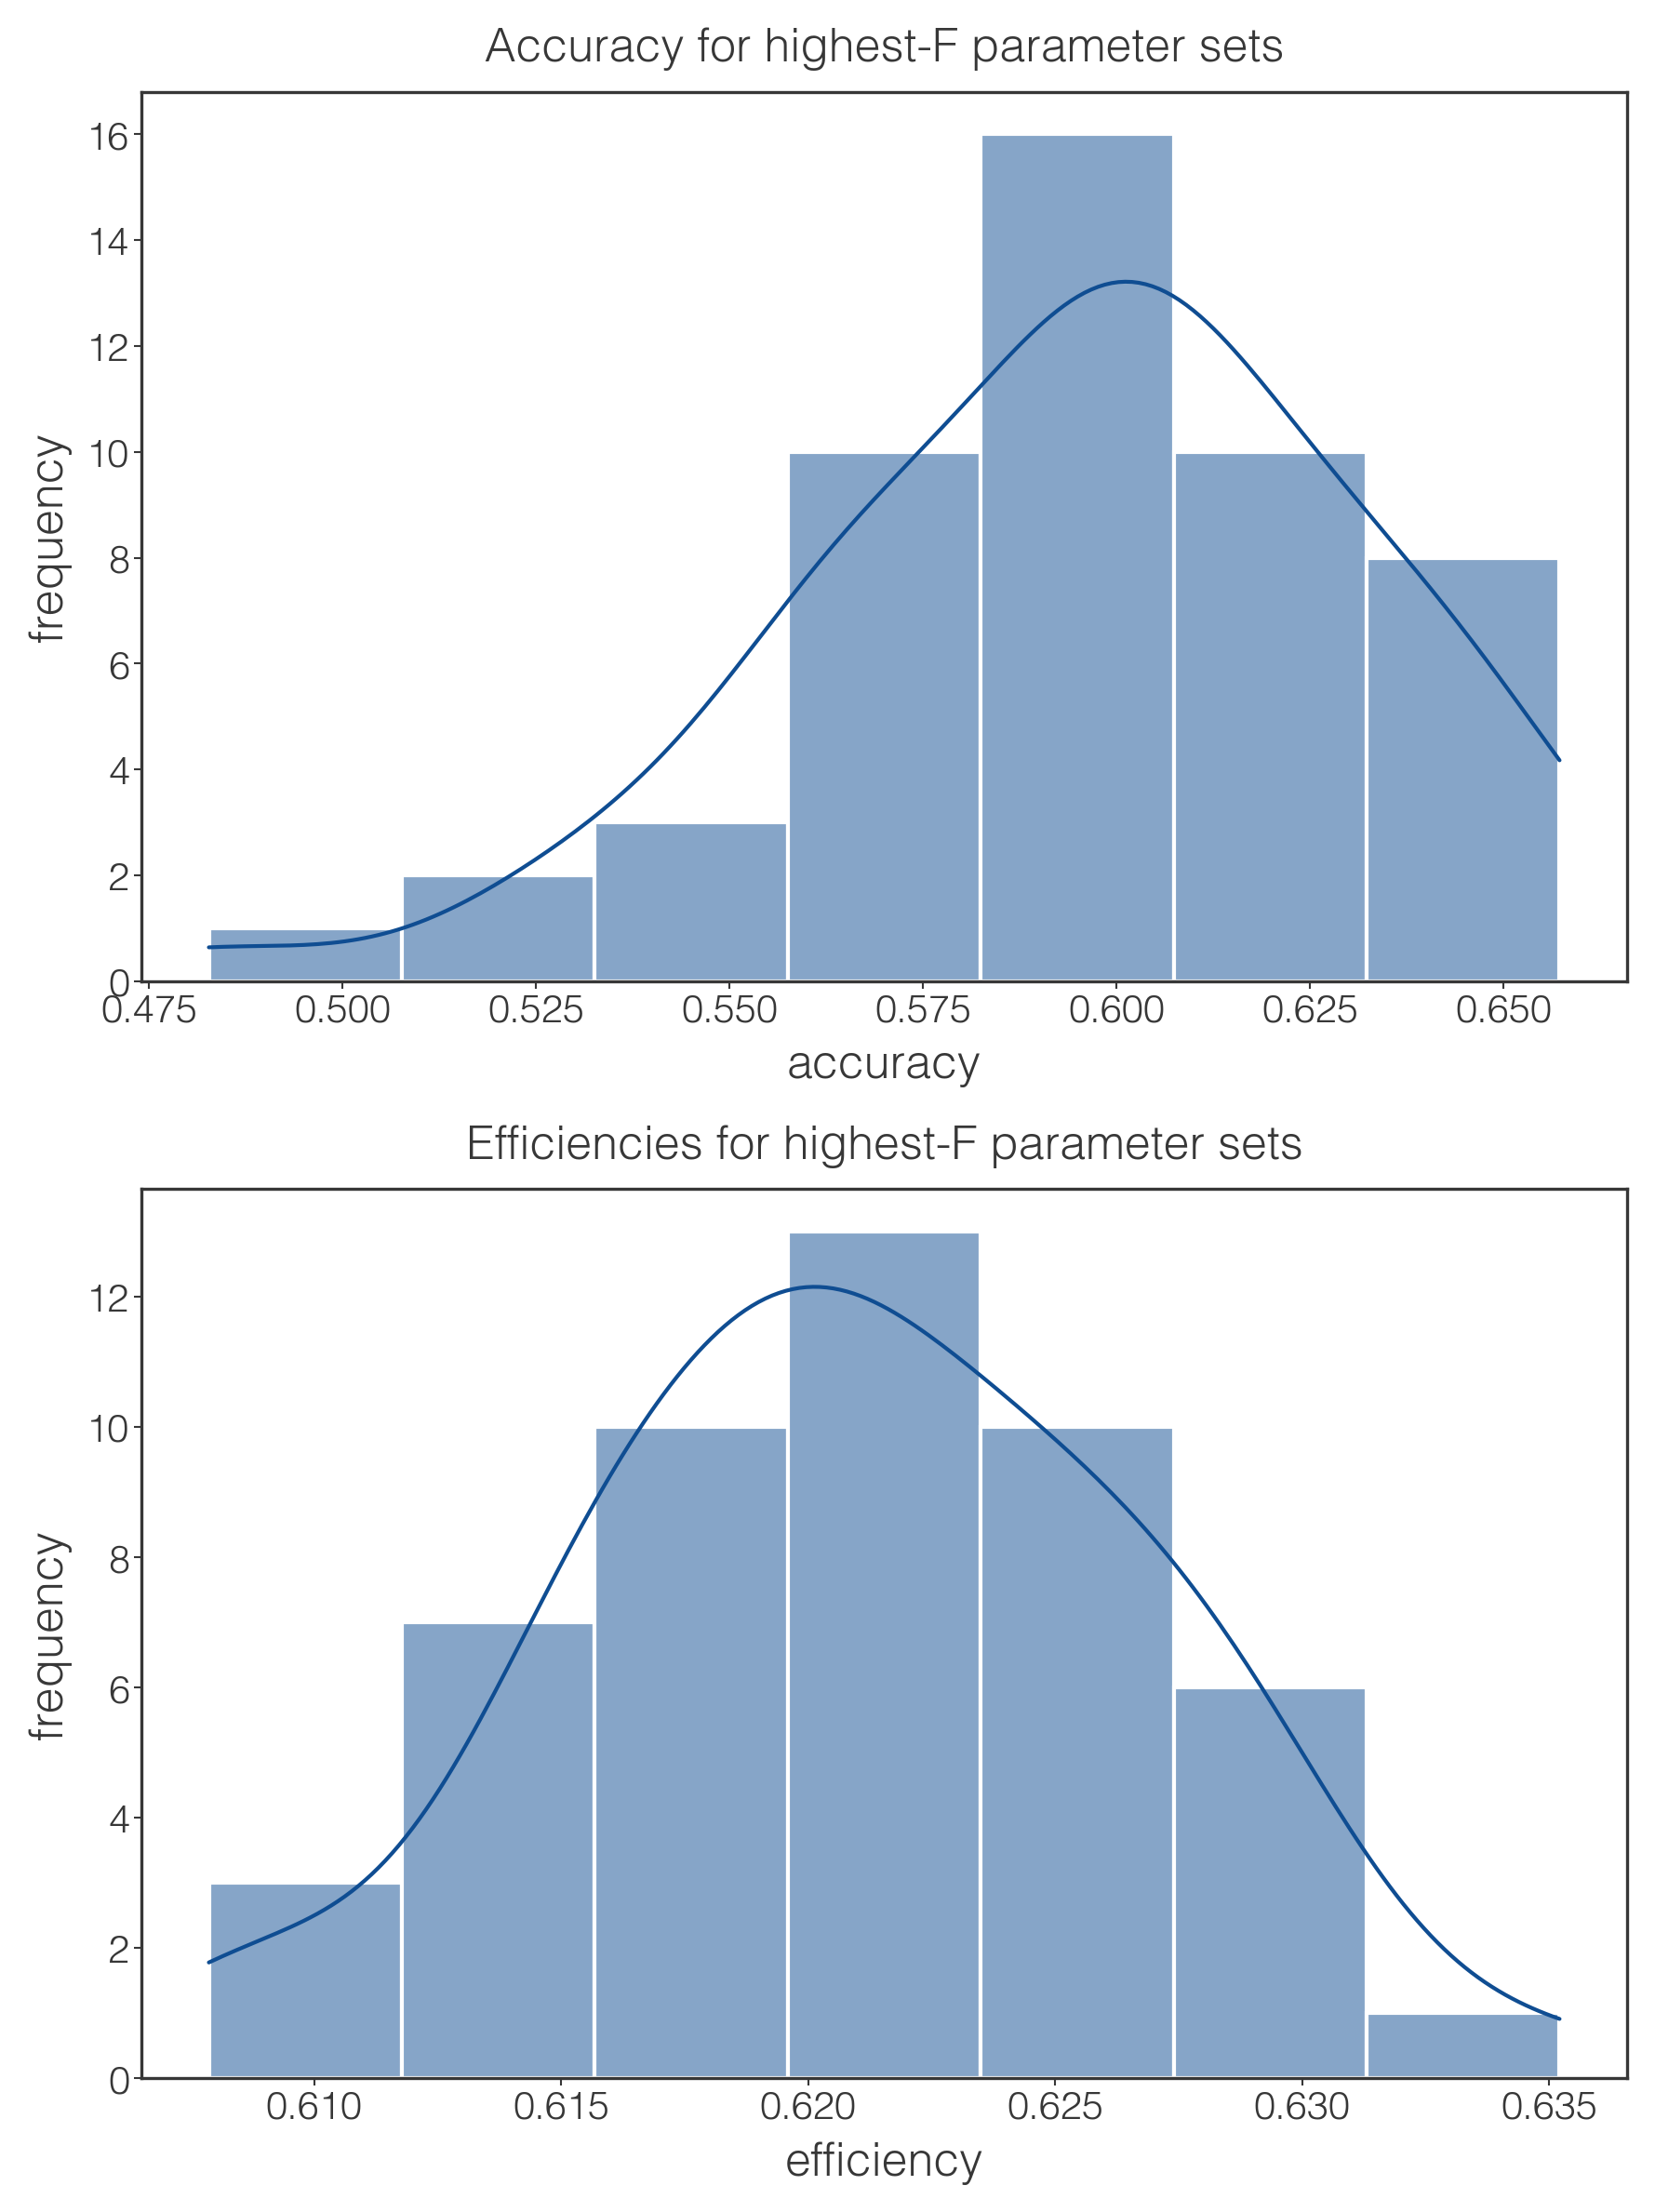

(0.5953250000000001, 0.6210463673469387)

In [31]:
infiles = './data/pos0p032_neg0p001/out/*csv'
N = 50
metric_column = 'mean_sensitivity'
report_params=None

viz_batch_optim(infiles, N, metric_column, beta=1, viz_dist=True, plt_agg=False, report_params=False)

## Processing simulation data

For each of 15 cooperativity scenarios, we perform the analysis described in the manuscript/supporting information, including selecting the top $ (k,t,r) $ parameters for each landscape, performing statistical analysis on the best accuracy/efficiency metrics, etc. Note that accuracy refers to the `mean_sensitivity` column in the output csvs, not `accuracy` or `coop_accuracy`.

In [18]:
def batch_proc_grid_dir(base_dir, N=50):
    """
    Process all directories and create CSV for accuracy analysis.
    Also generates parameter reports for each directory.
    Only considers rows where target_metric == 'coop'.
    
    Parameters:
    - base_dir: path to directory containing all the pos*_neg* directories
    - N: parameter for viz_batch_optim
    """
    
    acc_results = []
    
    # Find all directories matching the pattern
    pattern = os.path.join(base_dir, 'pos*_neg*')
    directories = glob.glob(pattern)
    
    for dir_path in sorted(directories):
        dir_name = os.path.basename(dir_path)
        print(f"Processing {dir_name}...")
        
        # Extract p_pos and p_neg from directory name
        match = re.search(r'pos([0-9]+p[0-9]+)_neg([0-9]+p[0-9]+)', dir_name)
        if not match:
            print(f"Warning: Could not parse p_pos/p_neg from {dir_name}")
            continue
            
        pos_str, neg_str = match.groups()
        p_pos = float(pos_str.replace('p', '.'))
        p_neg = float(neg_str.replace('p', '.'))
        
        # Set up file paths
        infiles = os.path.join(dir_path, 'out', '*csv')
        
        # Check if files exist
        if not glob.glob(infiles):
            print(f"Warning: No CSV files found in {infiles}")
            continue
        
        # Set up parameter report path
        acc_params_path = os.path.join(dir_path, 'compiled_params_acc.csv')
        
        # Process accuracy
        try:
            result = viz_batch_optim(
                infiles, N, 'mean_sensitivity', 
                beta=1, viz_dist=False, plt_agg=False, 
                report_params=acc_params_path, coop_only=True
            )
            if result[0] is not None:  # Check if we got valid results
                mean_acc, mean_eff_acc = result
                acc_results.append({
                    'p_pos': p_pos, 
                    'p_neg': p_neg, 
                    'accuracy': mean_acc, 
                    'efficiency': mean_eff_acc
                })
            else:
                print(f"No valid accuracy data for {dir_name}")
                acc_results.append({
                    'p_pos': p_pos, 
                    'p_neg': p_neg, 
                    'accuracy': None, 
                    'efficiency': None
                })
        except Exception as e:
            print(f"Error processing {dir_name} with mean_sensitivity: {e}")
            acc_results.append({
                'p_pos': p_pos, 
                'p_neg': p_neg, 
                'accuracy': None, 
                'efficiency': None
            })
    
    # Create DataFrame and save
    acc_df = pd.DataFrame(acc_results)
    
    acc_csv = os.path.join(base_dir, 'agg_accuracy_efficiency.csv')
    
    acc_df.to_csv(acc_csv, index=False)
    
    print(f"Accuracy results saved to {acc_csv}")
    
    return acc_df

In [20]:
base_directory = './data'
acc_df = batch_proc_grid_dir(base_directory, N=50)

Processing pos0p001_neg0p001...
Parameter report saved to ./data/pos0p001_neg0p001/compiled_params_acc.csv
Processing pos0p001_neg0p01...
Parameter report saved to ./data/pos0p001_neg0p01/compiled_params_acc.csv
Processing pos0p001_neg0p032...
Parameter report saved to ./data/pos0p001_neg0p032/compiled_params_acc.csv
Processing pos0p001_neg0p1...
Parameter report saved to ./data/pos0p001_neg0p1/compiled_params_acc.csv
Processing pos0p001_neg0p32...
Parameter report saved to ./data/pos0p001_neg0p32/compiled_params_acc.csv
Processing pos0p01_neg0p001...
Parameter report saved to ./data/pos0p01_neg0p001/compiled_params_acc.csv
Processing pos0p01_neg0p01...
Parameter report saved to ./data/pos0p01_neg0p01/compiled_params_acc.csv
Processing pos0p01_neg0p032...
Parameter report saved to ./data/pos0p01_neg0p032/compiled_params_acc.csv
Processing pos0p01_neg0p1...
Parameter report saved to ./data/pos0p01_neg0p1/compiled_params_acc.csv
Processing pos0p01_neg0p32...
Parameter report saved to ./d

What do the top-performing param_sets look like across diff landscapes?

In [23]:
def collect_top_params(base_dir):
    """
    Collect top-performing parameters from each directory's compiled_params files.
    Only considers rows where target_metric == 'coop'.
    
    Parameters:
    - base_dir: path to directory containing all the pos*_neg* directories
    
    Returns:
    - acc_params_df: DataFrame with top accuracy parameters for each p_pos/p_neg combo
    """
    
    acc_params = []
    
    # Find all directories matching the pattern
    pattern = os.path.join(base_dir, 'pos*_neg*')
    directories = glob.glob(pattern)
    
    for dir_path in sorted(directories):
        dir_name = os.path.basename(dir_path)
        print(f"Processing {dir_name}...")
        
        # Extract p_pos and p_neg from directory name
        match = re.search(r'pos([0-9]+p[0-9]+)_neg([0-9]+p[0-9]+)', dir_name)
        if not match:
            print(f"Warning: Could not parse p_pos/p_neg from {dir_name}")
            continue
            
        pos_str, neg_str = match.groups()
        p_pos = float(pos_str.replace('p', '.'))
        p_neg = float(neg_str.replace('p', '.'))
        
        # Process accuracy params (from coop-filtered data)
        acc_params_file = os.path.join(dir_path, 'compiled_params_acc.csv')
        if os.path.exists(acc_params_file):
            try:
                acc_df = pd.read_csv(acc_params_file)
                if not acc_df.empty:
                    # Get the top row (already sorted by count and avg_f_score)
                    top_acc_row = acc_df.iloc[0].copy()
                    # Add p_pos and p_neg
                    top_acc_row['p_pos'] = p_pos
                    top_acc_row['p_neg'] = p_neg
                    acc_params.append(top_acc_row.to_dict())
                else:
                    print(f"Warning: Empty accuracy params file for {dir_name}")
            except Exception as e:
                print(f"Error reading accuracy params for {dir_name}: {e}")
        else:
            print(f"Warning: No accuracy params file found for {dir_name}: {acc_params_file}")
    
    print(f"\nCollected {len(acc_params)} accuracy parameter sets")
    
    # Create DataFrame
    acc_params_df = pd.DataFrame(acc_params) if acc_params else pd.DataFrame()
    
    # Reorder columns to put p_pos and p_neg first
    if not acc_params_df.empty:
        cols = ['p_pos', 'p_neg'] + [col for col in acc_params_df.columns if col not in ['p_pos', 'p_neg']]
        acc_params_df = acc_params_df[cols]
        
        # Sort by p_pos and p_neg for easier reading
        acc_params_df = acc_params_df.sort_values(['p_pos', 'p_neg'])
    
    # Save to CSV file (no coop suffix in output filename)
    acc_output_file = os.path.join(base_dir, 'top_params_accuracy.csv')
    
    if not acc_params_df.empty:
        acc_params_df.to_csv(acc_output_file, index=False)
        print(f"Top accuracy parameters saved to {acc_output_file}")
    else:
        print("Warning: No accuracy parameter data collected")
    
    return acc_params_df

In [24]:
# Usage:
base_directory = './data'
acc_df = collect_top_params(base_directory)

Processing pos0p001_neg0p001...
Processing pos0p001_neg0p01...
Processing pos0p001_neg0p032...
Processing pos0p001_neg0p1...
Processing pos0p001_neg0p32...
Processing pos0p01_neg0p001...
Processing pos0p01_neg0p01...
Processing pos0p01_neg0p032...
Processing pos0p01_neg0p1...
Processing pos0p01_neg0p32...
Processing pos0p032_neg0p001...
Processing pos0p032_neg0p01...
Processing pos0p032_neg0p032...
Processing pos0p032_neg0p1...
Processing pos0p032_neg0p32...

Collected 15 accuracy parameter sets
Top accuracy parameters saved to ./data/top_params_accuracy.csv
